# Use straight skeletons for generating layout network
In generating layout network, it is not easy to handle corridor spaces. If we assign only one node to a long corridor, the network becomes too unrealistic. So we need a nice way to convert corridor spaces into graph structure.

In this notebook, we are going to use the [straight skeleton](https://en.wikipedia.org/wiki/Straight_skeleton) of corridor polygon.

In [3]:
import geopandas as gpd
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import LineString
import os
import polyskel

import warnings
warnings.filterwarnings('ignore')

### Read floorplan dataset

In [4]:
# read room polygons from esri gdb
gdb_path = os.path.expanduser('~/work/test-data/test.gdb')
rooms = gpd.read_file(gdb_path, layer=2)  

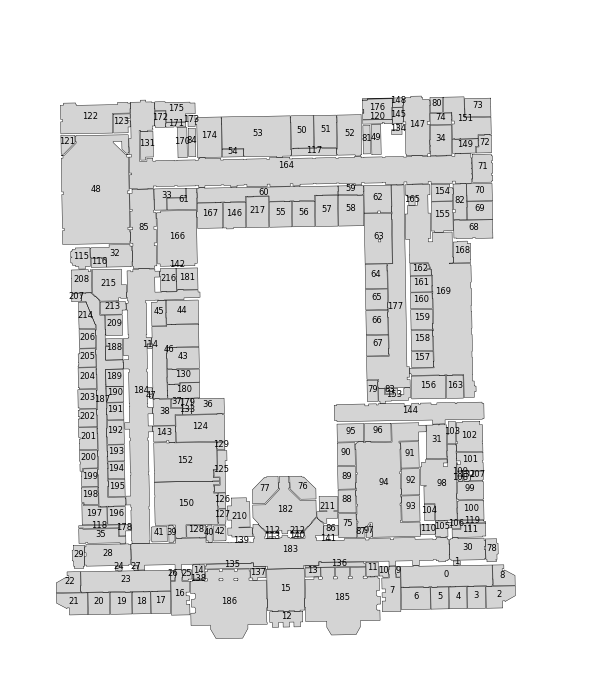

In [5]:
def default_ax(size=8):
    fig, ax = plt.subplots()
    fig.set_size_inches(size, size)
    ax.axison = False
    ax.set_aspect('equal')
    return ax

def show_rooms(df):
    ax = default_ax()
    df.plot(ax=ax, linewidth=0.3, color='#aaaaaa')
    for index in df.index:
        row = df.loc[index]
        plt.annotate(s=index, xy=[row.geometry.centroid.x, row.geometry.centroid.y],
                     horizontalalignment='center', fontsize=6)
    plt.show()

show_rooms(rooms)


### Straight skeleton for corridor 94
Let's create straight skeleton for the room 94. We need a list of (x,y) for this polygon.

In [6]:
def get_skeleton_network(df, rid):
    room = df.loc[rid]
    rpoly = room.geometry
    rbound = rpoly[0].boundary.coords
    skeleton = polyskel.skeletonize(list(rbound), [])
    sg = nx.Graph()
    for edge in skeleton:
        source = edge.source
        for sink in edge.sinks:
            sg.add_edge(source, sink)
    return sg

g = get_skeleton_network(rooms, 94)

In [7]:
# to plot the graph g with xy coords
pos = {}
for node in g.nodes():
    pos[node] = (node.x, node.y)

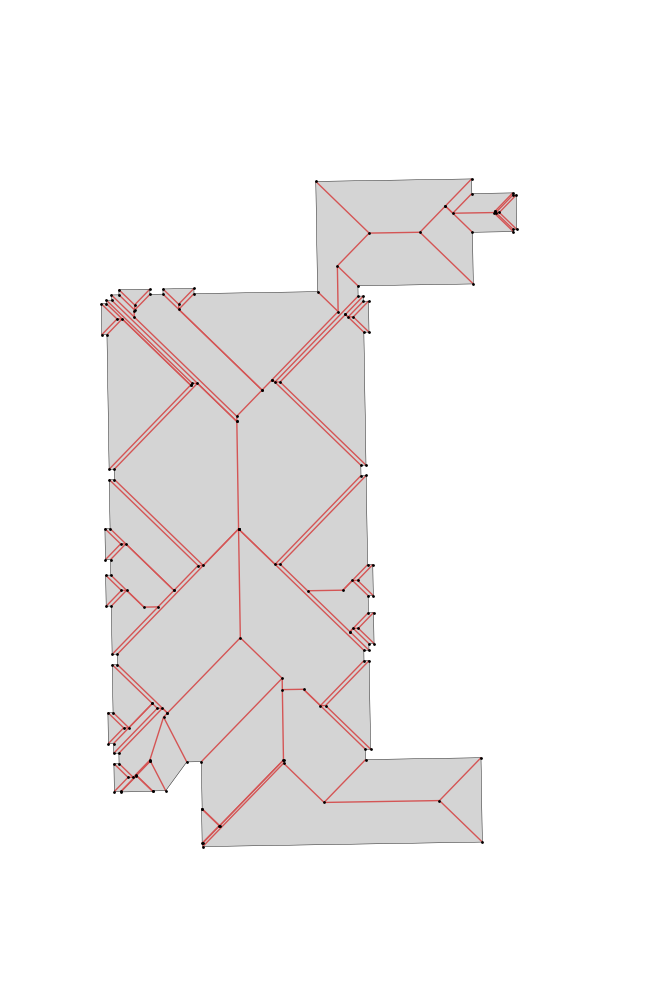

In [8]:
ax = default_ax(size=12)
rooms[rooms.index == 94].plot(ax=ax, linewidth=0.3, color='#aaaaaa')
nx.draw(g, pos, node_size = 1, ax=ax, edge_color='r')
plt.show()

#### We'd better remove leaf nodes (degree == 1).

In [9]:
leaves = set()
for node, degree in g.degree():
    if degree < 2:
        leaves.add(node)
g.remove_nodes_from(leaves)

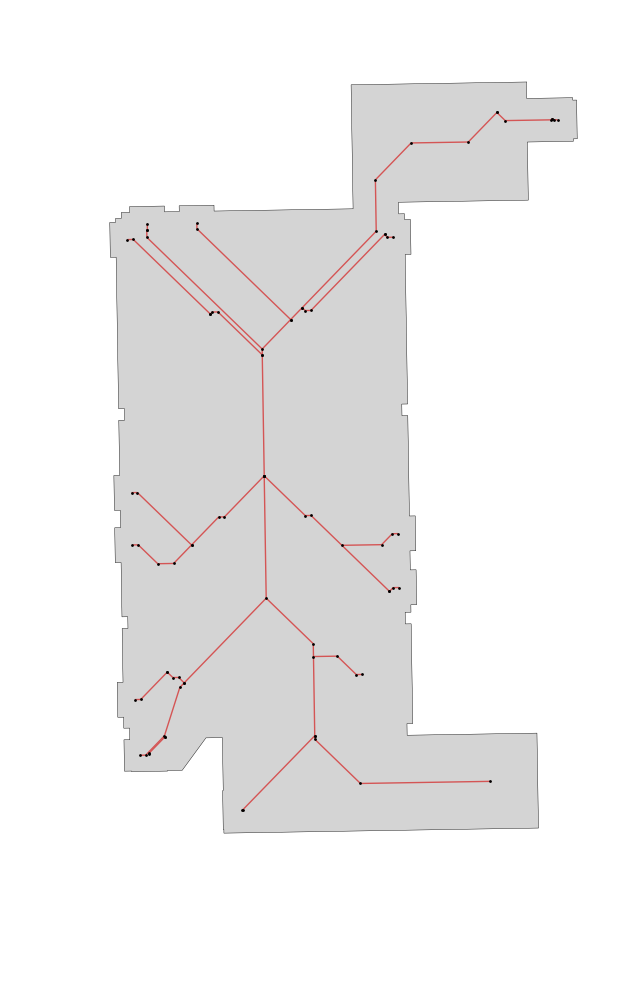

In [10]:
ax = default_ax(size=12)
rooms[rooms.index == 94].plot(ax=ax, linewidth=0.3, color='#aaaaaa')
nx.draw(g, pos, node_size = 1, ax=ax, edge_color='r')
plt.show()

Looks much better. But the skeleton reflects too minor geometrical changes. So let's create skeletons after we simplify the room polygon.

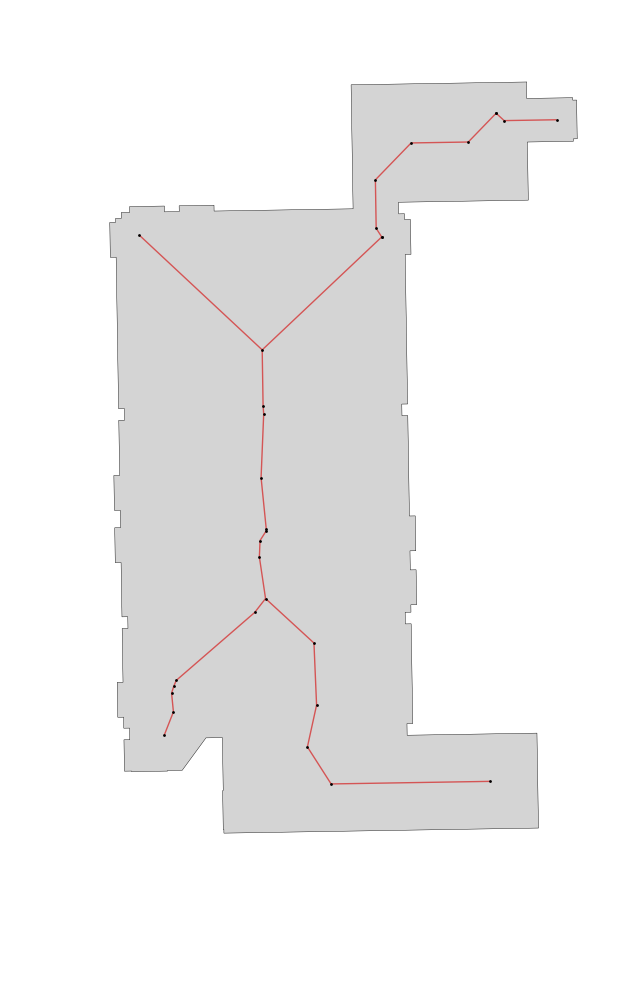

In [11]:
def get_skeleton_network_simplified(df, rid, tolerance=0.5):
    room = df.loc[rid]
    rpoly = room.geometry.simplify(tolerance)  # simplification
    rbound = rpoly.boundary.coords
    points = list(rbound)
    skeleton = polyskel.skeletonize(points, [])
    sg = nx.Graph()
    for edge in skeleton:
        source = edge.source
        for sink in edge.sinks:
            sg.add_edge(source, sink)
    leaves = set()
    for node, degree in sg.degree():
        if degree < 2:
            leaves.add(node)
    sg.remove_nodes_from(leaves)
    return sg

g = get_skeleton_network_simplified(rooms, 94)

pos = {}
for node in g.nodes():
    pos[node] = (node.x, node.y)

ax = default_ax(size=12)
rooms[rooms.index == 94].plot(ax=ax, linewidth=0.3, color='#aaaaaa')
nx.draw(g, pos, node_size = 1, ax=ax, edge_color='r')
plt.show()

Looks nice. Let's try with other corridors.

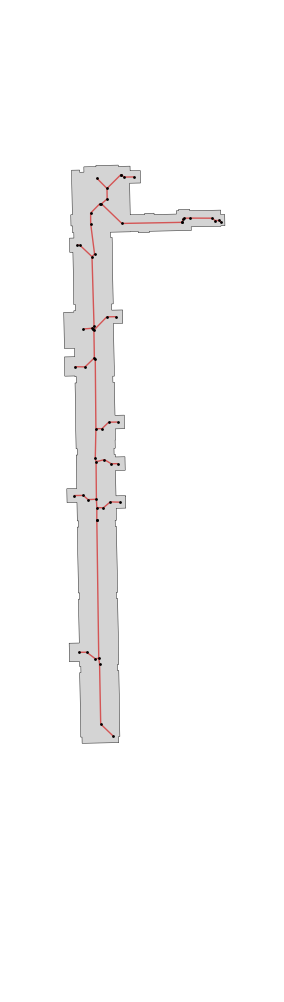

In [45]:
g = get_skeleton_network_simplified(rooms, 184)

pos = {}
for node in g.nodes():
    pos[node] = (node.x, node.y)

ax = default_ax(size=12)
rooms[rooms.index == 184].plot(ax=ax, linewidth=0.3, color='#aaaaaa')
nx.draw(g, pos, node_size = 1, ax=ax, edge_color='r')
plt.show()

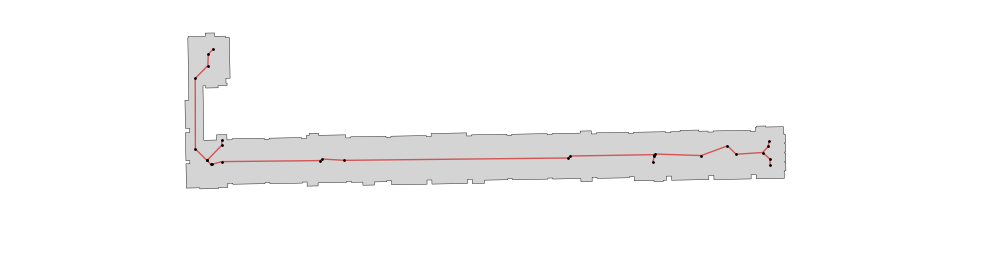

In [15]:
rid = 164
g = get_skeleton_network_simplified(rooms, rid, tolerance=1.2)

pos = {}
for node in g.nodes():
    pos[node] = (node.x, node.y)

ax = default_ax(size=12)
rooms[rooms.index == rid].plot(ax=ax, linewidth=0.3, color='#aaaaaa')
nx.draw(g, pos, node_size = 1, ax=ax, edge_color='r')
plt.show()

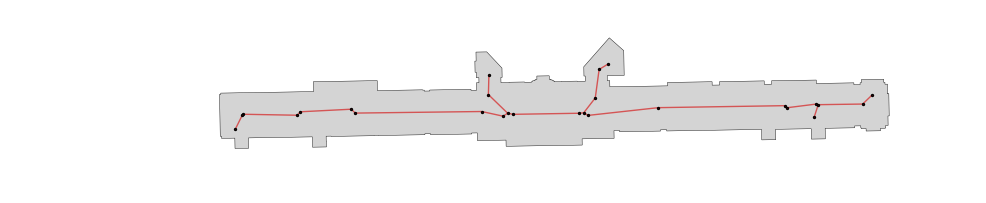

In [96]:
rid = 183
g = get_skeleton_network_simplified(rooms, rid, tolerance=2.5)

pos = {}
for node in g.nodes():
    pos[node] = (node.x, node.y)

ax = default_ax(size=12)
rooms[rooms.index == rid].plot(ax=ax, linewidth=0.3, color='#aaaaaa')
nx.draw(g, pos, node_size=2, linewidth=0, ax=ax, edge_color='r')
plt.show()

### Next...

In the next notebook, we will combine these skeletons with doors and rooms.